In [3]:
pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 914.9/914.9 kB 25.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 85.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 69.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 17.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 64.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [4]:
import ultralytics
import yaml
import os
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
from ultralytics import YOLO
from PIL import Image
import cv2

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [5]:
os.makedirs("/content/yolov8/datasets", exist_ok=True)

In [6]:
!unzip -q "/content/drive/MyDrive/uploads/Oxford Pets.v2-by-species.yolov5pytorch.zip" -d "/content/yolov8/datasets"

In [7]:
!ls "/content/yolov8/datasets"
!ls "/content/yolov8/datasets/data.yaml"
!ls "/content/yolov8/datasets/test"
!ls "/content/yolov8/datasets/train"
!ls "/content/yolov8/datasets/valid"

data.yaml  README.dataset.txt  README.roboflow.txt  test  train  valid
/content/yolov8/datasets/data.yaml
images	labels
images	labels
images	labels


In [8]:
#check label

def check_labels(label_dir):
  class_counts = Counter()

  for label_file in os.listdir(label_dir):
    with open(os.path.join(label_dir, label_file), "r") as f:
      for line in f.readlines():
        class_id = int(line.split()[0])
        class_counts[class_id] += 1

  return class_counts

for class_counts in check_labels("/content/yolov8/datasets/train/labels").items():
  print(f"Class {class_counts[0]}: {class_counts[1]} images")

Class 0: 817 images
Class 1: 1763 images


In [9]:
with open("/content/yolov8/datasets/data.yaml", "r") as f:
    print(f.read())


train: ../train/images
val: ../valid/images

nc: 2
names: ['cat', 'dog']


In [18]:
#repath for yaml
data_yaml = "/content/yolov8/datasets/data.yaml"

new_data_yaml = """train: /content/yolov8/datasets/train/images
val: /content/yolov8/datasets/valid/images

nc: 2
names: ['cat', 'dog']
"""

#overwrite file data.yaml
with open(data_yaml, "w") as f:
  f.write(new_data_yaml)

#check
with open(data_yaml, "r") as f:
  print(f.read())

train: /content/yolov8/datasets/train/images
val: /content/yolov8/datasets/valid/images

nc: 2
names: ['cat', 'dog']



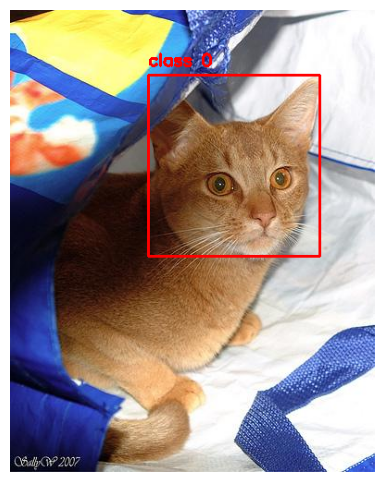

In [19]:
# display bounding box to check Annotation

img_dir = "/content/yolov8/datasets/train/images"
label_dir = "/content/yolov8/datasets/train/labels"

img_files = sorted(os.listdir(img_dir))

if len(img_files) == 0:
  print("none")
else:
  img_path = os.path.join(img_dir, img_files[0])
  label_path = os.path.join(label_dir, img_files[0].replace('.jpg', '.txt'))

  #load image
  img = cv2.imread(img_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  h, w, _ = img.shape

  #check file annatation
  if not os.path.exists(label_path):
    print(f"none {img_files[0]}")
  else:
    with open(label_path, "r") as f:
      for line in f.readlines():
        class_id, x_center, y_center, box_w, box_h = map(float, line.strip().split())

        #convert yolo -> pixel
        x1 = int((x_center - box_w / 2)* w)
        y1 = int((y_center - box_h / 2) * h)
        x2 = int((x_center + box_w / 2) * w)
        y2 = int((y_center + box_h / 2) * h)

        #draw bounding box
        cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 2)
        cv2.putText(img, f"class {int(class_id)}", (x1, y1 -10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)

        #display image
        plt.figure(figsize=(6, 6))
        plt.imshow(img)
        plt.axis("off")
        plt.show()

In [20]:
#training
model = YOLO("yolov8n.pt")

model.train(
    data="/content/yolov8/datasets/data.yaml",
    epochs=10,
    imgsz=640,
    batch=16,
    device="cuda"
)


Ultralytics 8.3.75 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/yolov8/datasets/data.yaml, epochs=10, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=cuda, workers=8, project=None, name=train3, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, s

100%|██████████| 755k/755k [00:00<00:00, 23.8MB/s]


Overriding model.yaml nc=80 with nc=2

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 100MB/s]


AMP: checks passed ✅


train: Scanning /content/yolov8/datasets/train/labels... 2576 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2576/2576 [00:01<00:00, 2339.04it/s]


train: New cache created: /content/yolov8/datasets/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.4' (you have '2.0.3'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning /content/yolov8/datasets/valid/labels... 736 images, 0 backgrounds, 0 corrupt: 100%|██████████| 736/736 [00:01<00:00, 710.54it/s]


val: New cache created: /content/yolov8/datasets/valid/labels.cache
Plotting labels to runs/detect/train3/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train3
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      2.28G      1.013      2.425      1.329         16        640: 100%|██████████| 161/161 [00:46<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:08<00:00,  2.75it/s]

                   all        736        738      0.773      0.719       0.81      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      2.15G      1.066      1.636      1.361         16        640: 100%|██████████| 161/161 [00:44<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.47it/s]


                   all        736        738      0.654      0.702      0.746      0.501

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      2.15G      1.105      1.251      1.371         16        640: 100%|██████████| 161/161 [00:43<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:05<00:00,  4.36it/s]


                   all        736        738      0.762       0.68      0.802      0.541

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      2.14G      1.024     0.9853      1.301         16        640: 100%|██████████| 161/161 [00:43<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.52it/s]

                   all        736        738      0.836      0.775      0.849      0.604



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      2.14G      0.941     0.8253      1.238         16        640: 100%|██████████| 161/161 [00:44<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:05<00:00,  4.39it/s]


                   all        736        738      0.898       0.87      0.941      0.695

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      2.14G     0.8748     0.6978      1.191         16        640: 100%|██████████| 161/161 [00:43<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.36it/s]

                   all        736        738      0.923      0.909      0.965      0.753



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      2.14G     0.8256     0.6376      1.162         16        640: 100%|██████████| 161/161 [00:43<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:05<00:00,  4.51it/s]


                   all        736        738      0.953      0.932      0.979      0.789

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      2.14G     0.7767     0.5565      1.128         16        640: 100%|██████████| 161/161 [00:43<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.51it/s]

                   all        736        738       0.94      0.957      0.983      0.802



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      2.14G     0.7018     0.4964      1.069         16        640: 100%|██████████| 161/161 [00:42<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:05<00:00,  4.37it/s]


                   all        736        738      0.978      0.944      0.986      0.805

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      2.14G     0.6446     0.4349      1.029         16        640: 100%|██████████| 161/161 [00:42<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:05<00:00,  4.21it/s]

                   all        736        738       0.97      0.966       0.99      0.842



10 epochs completed in 0.142 hours.
Optimizer stripped from runs/detect/train3/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train3/weights/best.pt, 6.2MB

Validating runs/detect/train3/weights/best.pt...
Ultralytics 8.3.75 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 168 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.36it/s]


                   all        736        738      0.968      0.967       0.99      0.842
                   cat        249        251      0.984      0.958      0.991      0.874
                   dog        487        487      0.953      0.975      0.988       0.81
Speed: 0.2ms preprocess, 1.9ms inference, 0.0ms loss, 2.1ms postprocess per image
Results saved to runs/detect/train3


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7a26cbc4ac10>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04804

⚠️ Không tìm thấy `metrics/mAP_50` trong file results.csv!


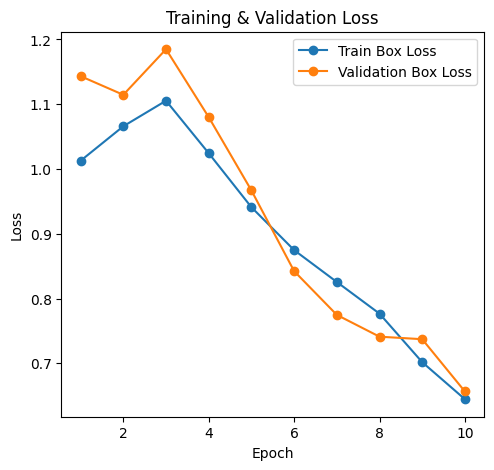

In [33]:


results_path = "/content/runs/detect/train3/results.csv"
df = pd.read_csv(results_path)


plt.figure(figsize=(12, 5))

# Loss Curve
plt.subplot(1, 2, 1)
plt.plot(df['epoch'], df['train/box_loss'], label="Train Box Loss", marker='o')
plt.plot(df['epoch'], df['val/box_loss'], label="Validation Box Loss", marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training & Validation Loss")

# Kiểm tra nếu `metrics/mAP_50` tồn tại thì mới vẽ
if "metrics/mAP_50" in df.columns:
    plt.subplot(1, 2, 2)
    plt.plot(df['epoch'], df['metrics/mAP_50'], label="mAP@0.5", marker='o')
    plt.plot(df['epoch'], df['metrics/mAP_50-95'], label="mAP@0.5:0.95", marker='o')
    plt.xlabel("Epoch")
    plt.ylabel("mAP")
    plt.legend()
    plt.title("Mean Average Precision (mAP)")
else:
    print("Không tìm thấy `metrics/mAP_50` trong file results.csv!")

plt.show()


In [35]:
model_trained= YOLO("/content/runs/detect/train3/weights/best.pt")

model_trained= YOLO("/content/runs/detect/train3/weights/best.pt")

image_dir = "/content/yolov8/datasets/test/images"

image_files = sorted([os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith(('.jpg', '.png', '.jpeg'))])

image_files = image_files[:20]

result = model_trained(image_files, save=True)

result = model_trained(image_files, save=True)


0: 640x640 1 cat, 5.0ms
1: 640x640 1 cat, 5.0ms
2: 640x640 1 cat, 5.0ms
3: 640x640 1 cat, 5.0ms
4: 640x640 1 cat, 5.0ms
5: 640x640 1 cat, 5.0ms
6: 640x640 1 cat, 5.0ms
7: 640x640 2 cats, 5.0ms
8: 640x640 1 cat, 5.0ms
9: 640x640 1 cat, 5.0ms
10: 640x640 (no detections), 5.0ms
11: 640x640 1 cat, 5.0ms
12: 640x640 1 dog, 5.0ms
13: 640x640 1 cat, 5.0ms
14: 640x640 (no detections), 5.0ms
15: 640x640 1 cat, 5.0ms
16: 640x640 2 cats, 5.0ms
17: 640x640 1 cat, 5.0ms
18: 640x640 1 cat, 5.0ms
19: 640x640 1 cat, 5.0ms
Speed: 4.9ms preprocess, 5.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict

0: 640x640 1 cat, 4.0ms
1: 640x640 1 cat, 4.0ms
2: 640x640 1 cat, 4.0ms
3: 640x640 1 cat, 4.0ms
4: 640x640 1 cat, 4.0ms
5: 640x640 1 cat, 4.0ms
6: 640x640 1 cat, 4.0ms
7: 640x640 2 cats, 4.0ms
8: 640x640 1 cat, 4.0ms
9: 640x640 1 cat, 4.0ms
10: 640x640 (no detections), 4.0ms
11: 640x640 1 cat, 4.0ms
12: 640x640 1 dog, 4.0ms
13: 640x640 1 cat, 4.0ms
14

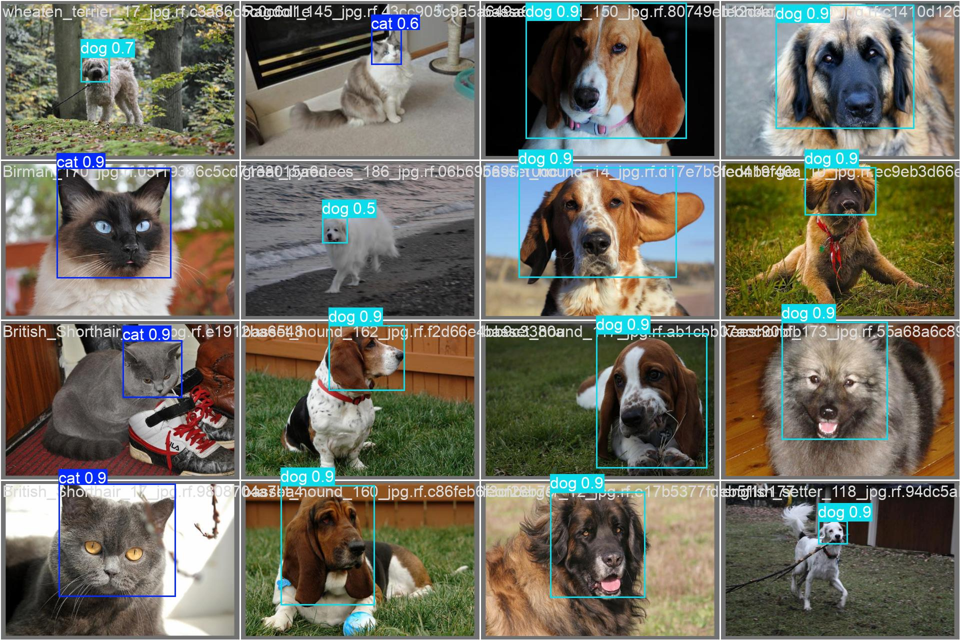

In [39]:

image_path = "/content/runs/detect/train3/val_batch1_pred.jpg"  cho phù hợp

image = Image.open(image_path)

resize = image.resize((int(image.width / 2), int(image.height / 2)))
resize
